In [12]:
import gzip
import warnings
import ujson

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict, defaultdict
from scipy import stats

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [6]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

# Read domain -> user sets

In [13]:
actors = defaultdict(set)

for path in tqdm(glob('../data/link-actor-graph.json/*.gz')):
    with gzip.open(path, 'rb') as fh:
        for line in fh:
            r = ujson.loads(line)
            actors[r['domain']].add(r['actor_id'])

100%|██████████| 10/10 [00:40<00:00,  4.25s/it]


In [14]:
actors.keys()

dict_keys(['nytimes.com', 'foxnews.com', 'thehill.com', 'washingtonpost.com', 'cnn.com', 'buzzfeed.com', 'breitbart.com', 'huffingtonpost.com', 'bloomberg.com', 'apnews.com', 'dailycaller.com', 'dailykos.com', 'wsj.com'])

In [20]:
def jaccard_sim(d1, d2):
    
    return (
        len(set.intersection(actors[d1], actors[d2])) /
        len(set.union(actors[d1], actors[d2]))
    )

In [32]:
def jaccard_dist(d1):
    
    sims = {
        d2: jaccard_sim(d1, d2)
        for d2 in actors.keys() if d2 != d1
    }
    
    total = sum(sims.values())
    sims_norm = {d: s / total for d, s in sims.items()}
    
    return sims_norm

In [33]:
jaccard_dist('foxnews.com')

{'nytimes.com': 0.07104296004530004,
 'thehill.com': 0.10009796465990546,
 'washingtonpost.com': 0.08958745829193467,
 'cnn.com': 0.07186624309161117,
 'buzzfeed.com': 0.05692175230039725,
 'breitbart.com': 0.1297033169026461,
 'huffingtonpost.com': 0.07053267892652575,
 'bloomberg.com': 0.07379073666135887,
 'apnews.com': 0.08848040141565276,
 'dailycaller.com': 0.11243299418765458,
 'dailykos.com': 0.04359105069331724,
 'wsj.com': 0.09195244282369613}

In [34]:
rows = []
for d1 in tqdm(domains):
    for d2, m in jaccard_dist(d1).items():
        rows.append((d1, d2, m))

100%|██████████| 13/13 [01:19<00:00,  5.36s/it]


In [35]:
mdf_actors = pd.DataFrame(rows, columns=('d1', 'd2', 'm'))

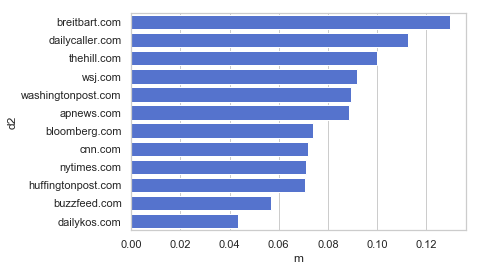

In [37]:
pdf = mdf_actors[mdf_actors.d1=='foxnews.com'].sort_values('m', ascending=False)
sns.barplot(x='m', y='d2', data=pdf, color='RoyalBlue')

# Read clf predictions

In [38]:
rows = []

for path in tqdm(glob('../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            line.pop('embedding')
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 66/66 [00:39<00:00,  1.69it/s]


In [39]:
df = pd.DataFrame(rows)

In [40]:
domains = df.label.unique()

In [41]:
domains

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [42]:
def title_pred_dist(domain):
    
    ddf = df[df.label==domain]
    
    masses = {
        d: ddf[f'p_{d}'].sum()
        for d in domains if d != domain
    }
    
    total = sum(masses.values())
    masses_norm = {d: m / total for d, m in masses.items()}
    
    return masses_norm

In [43]:
rows = []
for d1 in tqdm(domains):
    for d2, m in title_pred_dist(d1).items():
        rows.append((d1, d2, m))

100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


In [44]:
mdf_titles = pd.DataFrame(rows, columns=('d1', 'd2', 'm'))

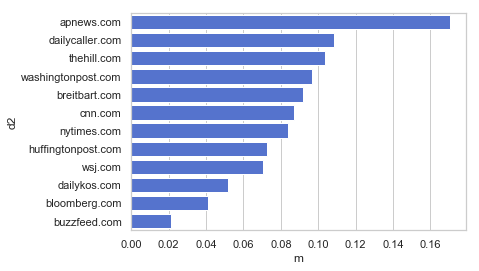

In [61]:
pdf = mdf_titles[mdf_titles.d1=='foxnews.com'].sort_values('m', ascending=False)
sns.barplot(x='m', y='d2', data=pdf, color='RoyalBlue')

In [47]:
mdf_titles.head(10)

,d1,d2,m
0,dailycaller.com,bloomberg.com,0.039809
1,dailycaller.com,thehill.com,0.153611
2,dailycaller.com,huffingtonpost.com,0.084996
3,dailycaller.com,dailykos.com,0.101812
4,dailycaller.com,nytimes.com,0.049286
5,dailycaller.com,cnn.com,0.069232
6,dailycaller.com,wsj.com,0.056071
7,dailycaller.com,apnews.com,0.052780
8,dailycaller.com,breitbart.com,0.140749
9,dailycaller.com,foxnews.com,0.125469


In [48]:
mdf_actors.head(10)

,d1,d2,m
0,breitbart.com,nytimes.com,0.052890
1,breitbart.com,foxnews.com,0.169357
2,breitbart.com,thehill.com,0.082251
3,breitbart.com,washingtonpost.com,0.070862
4,breitbart.com,cnn.com,0.047939
5,breitbart.com,buzzfeed.com,0.041355
6,breitbart.com,huffingtonpost.com,0.050333
7,breitbart.com,bloomberg.com,0.069146
8,breitbart.com,apnews.com,0.081409
9,breitbart.com,dailycaller.com,0.199275


In [57]:
ta_mass = mdf_titles.merge(mdf_actors, on=('d1', 'd2'), suffixes=('_titles', '_actors'))

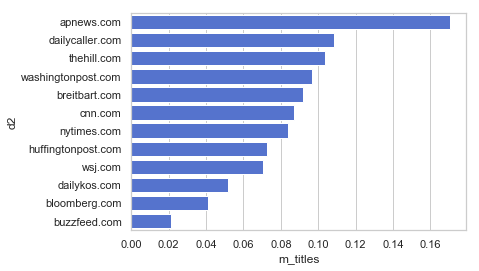

In [68]:
pdf = ta_mass[ta_mass.d1=='foxnews.com'].sort_values('m_titles', ascending=False)
sns.barplot(x='m_titles', y='d2', data=pdf, color='RoyalBlue')

In [72]:
pdf = ta_mass[ta_mass.d1=='foxnews.com'].sort_values('m_actors', ascending=False)
sns.barplot(data=pdf, color='RoyalBlue', hue='d2')

ValueError: Cannot use `hue` without `x` or `y`

In [70]:
ta_mass

,d1,d2,m_titles,m_actors
0,dailycaller.com,bloomberg.com,0.039809,0.067841
1,dailycaller.com,thehill.com,0.153611,0.092765
2,dailycaller.com,huffingtonpost.com,0.084996,0.059754
3,dailycaller.com,dailykos.com,0.101812,0.042716
4,dailycaller.com,nytimes.com,0.049286,0.050561
5,dailycaller.com,cnn.com,0.069232,0.053997
6,dailycaller.com,wsj.com,0.056071,0.087761
7,dailycaller.com,apnews.com,0.052780,0.083756
8,dailycaller.com,breitbart.com,0.140749,0.195772
9,dailycaller.com,foxnews.com,0.125469,0.144226
